In [1]:
import os
import numpy as np
import pandas as pd
import utils_sdss as utils

In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
# plt.style.use("ggplot")
%matplotlib inline

In [3]:
# load data
# load the unLRG sample list
listpath = "./BH_SDSS_cross_checked.xlsx"
data = pd.read_excel(listpath, "Sheet2")

In [4]:
extinction_u = data["extinction_u"]
extinction_g = data["extinction_g"]
extinction_r = data["extinction_r"]
extinction_i = data["extinction_i"]
extinction_z = data["extinction_z"]

cmodelmag_u = np.nan_to_num(data["cmodelmag_u"])
cmodelmag_g = np.nan_to_num(data["cmodelmag_g"])
cmodelmag_r = np.nan_to_num(data["cmodelmag_r"])
cmodelmag_i = np.nan_to_num(data["cmodelmag_i"])
cmodelmag_z = np.nan_to_num(data["cmodelmag_z"])

cmodelmagerr_u = np.nan_to_num(data["cmodelmagerr_u"])
cmodelmagerr_g = np.nan_to_num(data["cmodelmagerr_g"])
cmodelmagerr_r = np.nan_to_num(data["cmodelmagerr_r"])
cmodelmagerr_i = np.nan_to_num(data["cmodelmagerr_i"])
cmodelmagerr_z = np.nan_to_num(data["cmodelmagerr_z"])

In [5]:
# exclude bad sample
idx_u1 = np.where(cmodelmag_u != -9999)[0]
idx_u2 = np.where(cmodelmag_u != 0.0)[0]
idx_u3 = np.where(cmodelmag_u != 10000)[0]
idx = np.intersect1d(idx_u1,idx_u2)
idx = np.intersect1d(idx, idx_u3)

In [6]:
# load reconstruct k_correction
with open("../../result-171102/sdss/reconf_unLRG.dat", 'r') as fp:
    reconmags = fp.readlines()

In [7]:
# calc absolute magnitudes and save into excels
redshift = data["z"]
mag_abs = np.ones((len(redshift),))*10000
for j,i in enumerate(idx):
    z = redshift[i]
    dl = utils.calc_luminosity_distance(z) # luminosity distance [Mpc]
    mags = [cmodelmag_u[i],cmodelmag_g[i],cmodelmag_r[i],cmodelmag_r[i],cmodelmag_z[i]]
    exts = [extinction_u[i],extinction_g[i],extinction_r[i],extinction_r[i],extinction_z[i]]
    reconmag = reconmags[j].split(" ")
    mag_abs[i] = utils.calc_absmag(mags[2]-exts[2],dl.value,float(reconmag[3]))

In [8]:
mode = data["Type"]
idx1 = np.where(mode == 1)[0]
idx2 = np.where(mode == 2)[0]
idx3 = np.where(mode == 3)[0]
idx4 = np.where(mode == 4)[0]
idx5 = np.where(mode == 5)[0]
idx6 = np.where(mode == 6)[0]
idx2_same = np.intersect1d(idx,idx2)
idx3_same = np.intersect1d(idx,idx3)

In [9]:
BT = data["BT"]
idx_fr1 = np.where(BT == 1)[0]
idx_fr2 = np.where(BT == 2)[0]
idx_fr1 = np.intersect1d(idx, idx_fr1)
idx_fr2 = np.intersect1d(idx, idx_fr2)

In [10]:
flux = data["S_nvss"]
lumo = utils.flux_to_luminosity(redshift = redshift, flux = flux)

## Curve fitting

In [11]:
# curve fitting
from scipy.optimize import curve_fit

def line_curve(x,k,b):
    return k*x+b

### Data

In [12]:
lumo_fr1_typical = lumo[idx2_same] * 10**-22
lumo_fr2_typical = lumo[idx3_same] * 10**-22

mag_fr1_typical = mag_abs[idx2_same]
mag_fr2_typical = mag_abs[idx3_same]

In [13]:
lumo_fr1_like = lumo[idx_fr1] * 10**-22
lumo_fr2_like = lumo[idx_fr2] * 10**-22

mag_fr1_like = mag_abs[idx_fr1]
mag_fr2_like = mag_abs[idx_fr2]

In [14]:
mag_fr1 = np.hstack([mag_abs[idx_fr1], mag_abs[idx2_same]])
mag_fr2 = np.hstack([mag_abs[idx_fr2], mag_abs[idx3_same]])
lumo_fr1 = np.hstack([lumo[idx_fr1], lumo[idx2_same]]) * 10 ** -22
lumo_fr2 = np.hstack([lumo[idx_fr2], lumo[idx3_same]]) * 10 ** -22

## Curve fitting
- Reference: http://blog.csdn.net/wmn7q/article/details/53243751

In [15]:
# 分块取bin
# bin and extract averages of each bin
# Reference: http://blog.csdn.net/wmn7q/article/details/53243751
def scatter_to_bin(x, y, bins): 
    [num,edge] = np.histogram(x, bins)
    # get avgs and mids
    avg = np.zeros((len(num)))
    med = np.zeros((len(num)))
    var = np.zeros((len(num)))
    weights = np.zeros(y.shape)
    for i in range(len(num)):
        idx_l = np.where(x >= edge[i])
        idx_r = np.where(x < edge[i+1])
        idx = np.intersect1d(idx_l,idx_r)
        if len(idx):
            avg[i] = np.mean(y[idx])
            med[i] = np.median(y[idx])
            var[i] = np.var(y[idx]) 
            # weighted value
            weights[idx] = var[i]
            # weights[idx] = np.abs(weights[idx] - med[i])
    
    weights[np.where(weights==0)] = 10000                    
    bin_cnt = (edge[1:] - edge[0:-1])/2 + edge[0:-1]
    
    return weights,avg,var

In [16]:
def line_fit(x,y,sigma=None,p=[]):
    # remove nan points
    idx_x = np.isnan(x)
    idx_y = np.isnan(y)
    idx = ~(idx_x+idx_y)
    # fitting
    popt,perr = curve_fit(line_curve,x[idx],y[idx],p0=p,sigma=sigma)
    
    return popt,perr

## Weights

In [50]:
# bins_lumo = np.arange(1,6,0.5)
bins_mag = np.arange(-25,-20,0.5)

In [51]:
weights_fr1_t,avg_fr1_t,var_fr1_t = scatter_to_bin(mag_fr1_typical,np.log10(lumo_fr1_typical),bins_mag)
weights_fr2_t,avg_fr2_t,var_fr2_t = scatter_to_bin(mag_fr2_typical,np.log10(lumo_fr2_typical),bins_mag)

In [52]:
weights_fr1_l,avg_fr1_l,var_fr1_l = scatter_to_bin(mag_fr1_like,np.log10(lumo_fr1_like),bins_mag)
weights_fr2_l,avg_fr2_l,var_fr2_l = scatter_to_bin(mag_fr2_like,np.log10(lumo_fr2_like),bins_mag)

In [53]:
weights_fr1,avg_fr1,var_fr1 = scatter_to_bin(mag_fr1,np.log10(lumo_fr1),bins_mag)
weights_fr2,avg_fr2,var_fr2 = scatter_to_bin(mag_fr2,np.log10(lumo_fr2),bins_mag)

## Fitting

In [54]:
p_avg_fr1_t,_ = line_fit(mag_fr1_typical,np.log10(lumo_fr1_typical),sigma=weights_fr1_t,p=[-1,1])
p_avg_fr2_t,_ = line_fit(mag_fr2_typical,np.log10(lumo_fr2_typical),sigma=weights_fr2_t,p=[-1,1])

In [55]:
p_avg_fr1_l,_ = line_fit(mag_fr1_like,np.log10(lumo_fr1_like),sigma=weights_fr1_l,p=[-1,1])
p_avg_fr2_l,_ = line_fit(mag_fr2_like,np.log10(lumo_fr2_like),sigma=weights_fr2_l,p=[-1,1])

In [56]:
p_avg_fr1,_ = line_fit(mag_fr1,np.log10(lumo_fr1),sigma=weights_fr1,p=[-1,1])
p_avg_fr2,_ = line_fit(mag_fr2,np.log10(lumo_fr2),sigma=weights_fr2,p=[-1,1])

### plot result

In [57]:
x_lumo = np.arange(1,6,0.01)
x_mag = np.arange(-25,-20,0.01)

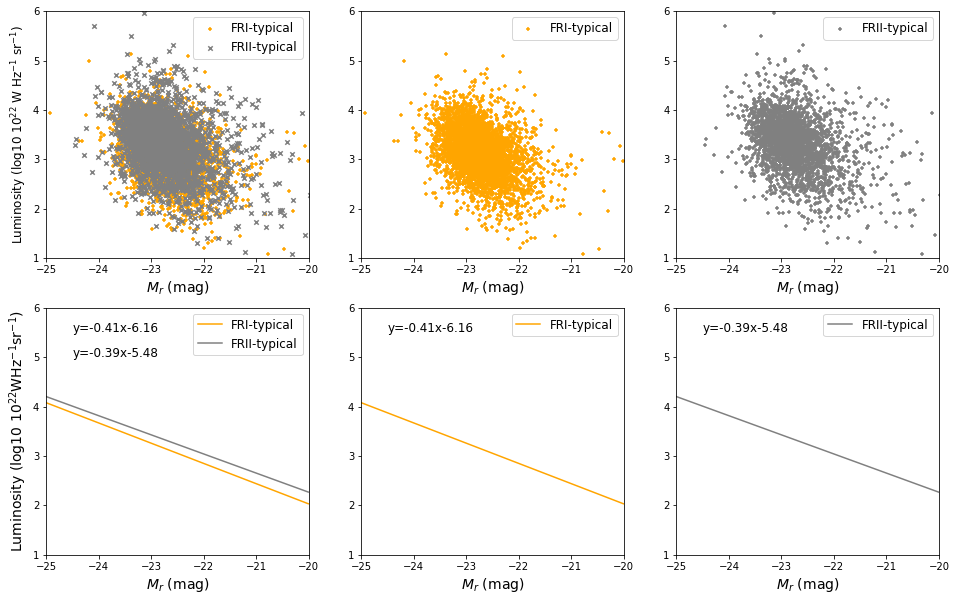

In [58]:
# Typical
plt.rcParams["figure.figsize"] = [16.0, 10]

from matplotlib import gridspec 
gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1],height_ratios=[1,1]) 

ax0 = plt.subplot(gs[0]) 
ax0.scatter(mag_fr1_typical,np.log10(lumo_fr1_typical),c='orange',marker='+',s=20)
ax0.scatter(mag_fr2_typical,np.log10(lumo_fr2_typical),c='grey',marker='x',s=20)
plt.ylabel("Luminosity (log10 $10^{22}$ $\mathrm{W}$ $\mathrm{Hz}^{-1}$ $\mathrm{sr}^{-1}$)",fontsize=12)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRI-typical","FRII-typical"],fontsize=12)

ax1 = plt.subplot(gs[1]) 
ax1.scatter(mag_fr1_typical,np.log10(lumo_fr1_typical),c='orange',marker='+',s=20)
# plt.ylabel("Luminosity (log10 $10^{22}$ $\mathrm{W}$ $\mathrm{Hz}^{-1}$ $\mathrm{sr}^{-1}$)",fontsize=15)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRI-typical"],fontsize=12)

ax2 = plt.subplot(gs[2]) 
ax2.scatter(mag_fr2_typical,np.log10(lumo_fr2_typical),c='grey',marker='+',s=20)
# plt.ylabel("Luminosity (log10 $10^{22}$ $\mathrm{W}$ $\mathrm{Hz}^{-1}$ $\mathrm{sr}^{-1}$)",fontsize=15)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRII-typical"],fontsize=12)

ax3 = plt.subplot(gs[3]) 
ax3.plot(x_mag, line_curve(x_mag,*p_avg_fr1_t), color='orange',linestyle='-')
ax3.plot(x_mag, line_curve(x_mag,*p_avg_fr2_t), color='grey',linestyle='-')
ax3.text(-24.5,5.5,"y=%.2fx%.2f" % tuple(p_avg_fr1_t),fontsize=12)
ax3.text(-24.5,5,"y=%.2fx%.2f" % tuple(p_avg_fr2_t),fontsize=12)
plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W}\mathrm{Hz}^{-1}\mathrm{sr}^{-1}$)",fontsize=14)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRI-typical","FRII-typical"],fontsize=12)

ax4 = plt.subplot(gs[4]) 
ax4.plot(x_mag, line_curve(x_mag,*p_avg_fr1_t), color='orange',linestyle='-')
ax4.text(-24.5,5.5,"y=%.2fx%.2f" % tuple(p_avg_fr1_t),fontsize=12)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRI-typical"],fontsize=12)

ax5 = plt.subplot(gs[5]) 
ax5.plot(x_mag, line_curve(x_mag,*p_avg_fr2_t), color='grey',linestyle='-')
ax5.text(-24.5,5.5,"y=%.2fx%.2f" % tuple(p_avg_fr2_t),fontsize=12)
# plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W}\mathrm{Hz}^{-1}\mathrm{sr}^{-1}$)",fontsize=14)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRII-typical"],fontsize=12)

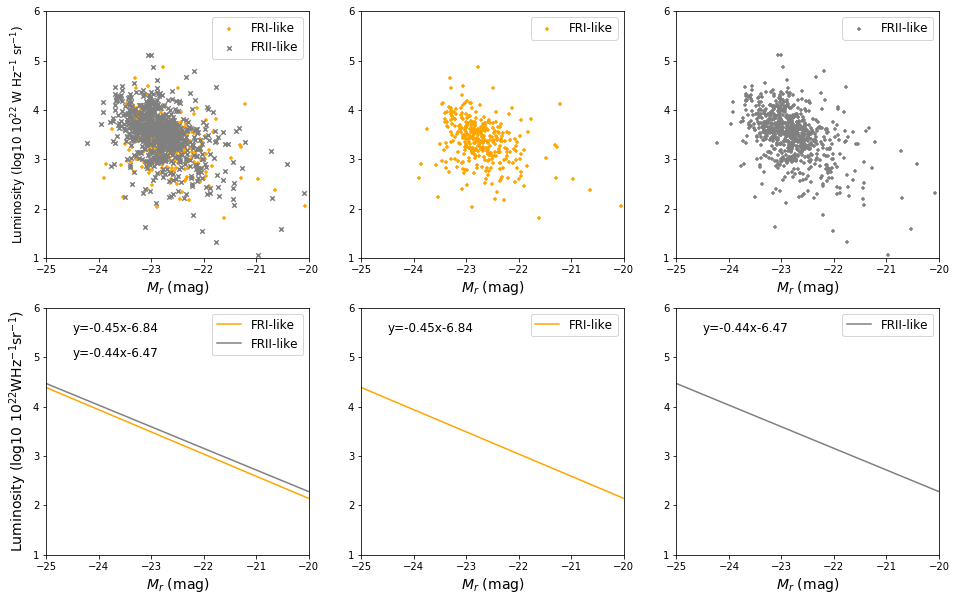

In [59]:
# like
plt.rcParams["figure.figsize"] = [16.0, 10]

from matplotlib import gridspec 
gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1],height_ratios=[1,1]) 

ax0 = plt.subplot(gs[0]) 
ax0.scatter(mag_fr1_like,np.log10(lumo_fr1_like),c='orange',marker='+',s=20)
ax0.scatter(mag_fr2_like,np.log10(lumo_fr2_like),c='grey',marker='x',s=20)
plt.ylabel("Luminosity (log10 $10^{22}$ $\mathrm{W}$ $\mathrm{Hz}^{-1}$ $\mathrm{sr}^{-1}$)",fontsize=12)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRI-like","FRII-like"],fontsize=12)

ax1 = plt.subplot(gs[1]) 
ax1.scatter(mag_fr1_like,np.log10(lumo_fr1_like),c='orange',marker='+',s=20)
# plt.ylabel("Luminosity (log10 $10^{22}$ $\mathrm{W}$ $\mathrm{Hz}^{-1}$ $\mathrm{sr}^{-1}$)",fontsize=15)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRI-like"],fontsize=12)

ax2 = plt.subplot(gs[2]) 
ax2.scatter(mag_fr2_like,np.log10(lumo_fr2_like),c='grey',marker='+',s=20)
# plt.ylabel("Luminosity (log10 $10^{22}$ $\mathrm{W}$ $\mathrm{Hz}^{-1}$ $\mathrm{sr}^{-1}$)",fontsize=15)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRII-like"],fontsize=12)

ax3 = plt.subplot(gs[3]) 
ax3.plot(x_mag, line_curve(x_mag,*p_avg_fr1_l), color='orange',linestyle='-')
ax3.plot(x_mag, line_curve(x_mag,*p_avg_fr2_l), color='grey',linestyle='-')
ax3.text(-24.5,5.5,"y=%.2fx%.2f" % tuple(p_avg_fr1_l),fontsize=12)
ax3.text(-24.5,5,"y=%.2fx%.2f" % tuple(p_avg_fr2_l),fontsize=12)
plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W}\mathrm{Hz}^{-1}\mathrm{sr}^{-1}$)",fontsize=14)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRI-like","FRII-like"],fontsize=12)

ax4 = plt.subplot(gs[4]) 
ax4.plot(x_mag, line_curve(x_mag,*p_avg_fr1_l), color='orange',linestyle='-')
ax4.text(-24.5,5.5,"y=%.2fx%.2f" % tuple(p_avg_fr1_l),fontsize=12)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRI-like"],fontsize=12)

ax5 = plt.subplot(gs[5]) 
ax5.plot(x_mag, line_curve(x_mag,*p_avg_fr2_l), color='grey',linestyle='-')
ax5.text(-24.5,5.5,"y=%.2fx%.2f" % tuple(p_avg_fr2_l),fontsize=12)
# plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W}\mathrm{Hz}^{-1}\mathrm{sr}^{-1}$)",fontsize=14)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRII-like"],fontsize=12)

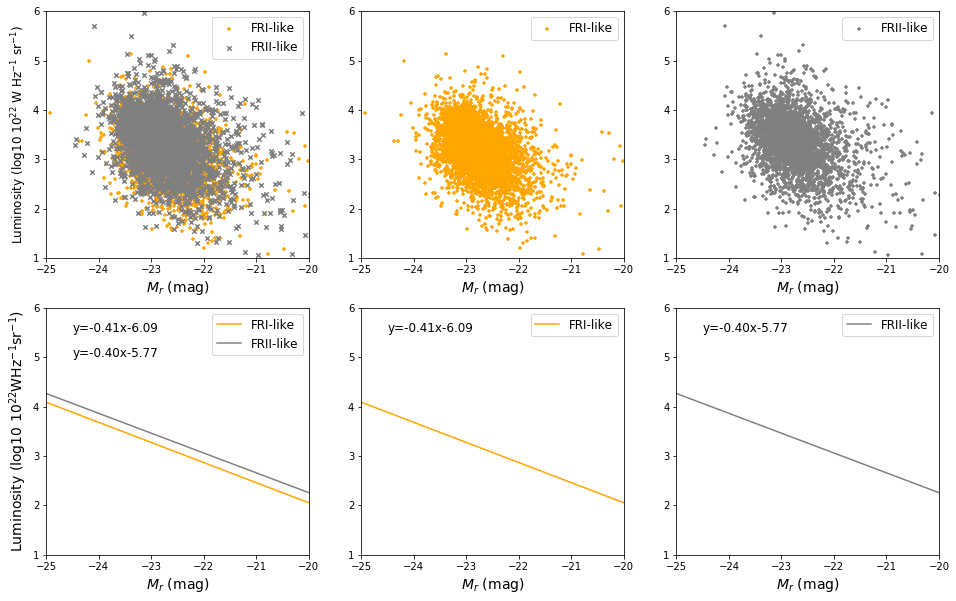

In [60]:
# like
plt.rcParams["figure.figsize"] = [16.0, 10]

from matplotlib import gridspec 
gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1],height_ratios=[1,1]) 

ax0 = plt.subplot(gs[0]) 
ax0.scatter(mag_fr1,np.log10(lumo_fr1),c='orange',marker='+',s=20)
ax0.scatter(mag_fr2,np.log10(lumo_fr2),c='grey',marker='x',s=20)
plt.ylabel("Luminosity (log10 $10^{22}$ $\mathrm{W}$ $\mathrm{Hz}^{-1}$ $\mathrm{sr}^{-1}$)",fontsize=12)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRI-like","FRII-like"],fontsize=12)

ax1 = plt.subplot(gs[1]) 
ax1.scatter(mag_fr1,np.log10(lumo_fr1),c='orange',marker='+',s=20)
# plt.ylabel("Luminosity (log10 $10^{22}$ $\mathrm{W}$ $\mathrm{Hz}^{-1}$ $\mathrm{sr}^{-1}$)",fontsize=15)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRI-like"],fontsize=12)

ax2 = plt.subplot(gs[2]) 
ax2.scatter(mag_fr2,np.log10(lumo_fr2),c='grey',marker='+',s=20)
# plt.ylabel("Luminosity (log10 $10^{22}$ $\mathrm{W}$ $\mathrm{Hz}^{-1}$ $\mathrm{sr}^{-1}$)",fontsize=15)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRII-like"],fontsize=12)

ax3 = plt.subplot(gs[3]) 
ax3.plot(x_mag, line_curve(x_mag,*p_avg_fr1), color='orange',linestyle='-')
ax3.plot(x_mag, line_curve(x_mag,*p_avg_fr2), color='grey',linestyle='-')
ax3.text(-24.5,5.5,"y=%.2fx%.2f" % tuple(p_avg_fr1),fontsize=12)
ax3.text(-24.5,5,"y=%.2fx%.2f" % tuple(p_avg_fr2),fontsize=12)
plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W}\mathrm{Hz}^{-1}\mathrm{sr}^{-1}$)",fontsize=14)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRI-like","FRII-like"],fontsize=12)

ax4 = plt.subplot(gs[4]) 
ax4.plot(x_mag, line_curve(x_mag,*p_avg_fr1), color='orange',linestyle='-')
ax4.text(-24.5,5.5,"y=%.2fx%.2f" % tuple(p_avg_fr1),fontsize=12)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRI-like"],fontsize=12)

ax5 = plt.subplot(gs[5]) 
ax5.plot(x_mag, line_curve(x_mag,*p_avg_fr2), color='grey',linestyle='-')
ax5.text(-24.5,5.5,"y=%.2fx%.2f" % tuple(p_avg_fr2),fontsize=12)
# plt.ylabel("Luminosity (log10 $10^{22} \mathrm{W}\mathrm{Hz}^{-1}\mathrm{sr}^{-1}$)",fontsize=14)
plt.xlabel("$M_r$ (mag)",fontsize=14)
plt.xlim([-25, -20])
plt.ylim([1,6])
plt.legend(["FRII-like"],fontsize=12)